<div class="alert alert-success">
        <strong>[Ants & Bees Competition](https://www.kaggle.com/datasets/gauravduttakiit/ants-bees)</strong>
        <img src='1.png'/>
        
    
    
</div>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix
import splitfolders

import torch
import torch.nn as nn # neural network moudle
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *
from data_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

## Data

- train: learning the **parameters** of the model.
- valid: learning **hyper-parameters**.
- test
- development

In [6]:
input_folder='dataset/hymenoptera_data/'
splitfolders.ratio(input_folder, output="Splite_Insects", seed=1337, ratio=(.7, 0.2,0.1)) 

Copying files: 0 files [00:00, ? files/s]


In [7]:
DATA_DIR = 'dataset/hymenoptera_data'
sz = 224
batch_size = 16


In [8]:
os.listdir(DATA_DIR)

['train', 'val']

In [30]:
trn_dir = f'{DATA_DIR}/train'
val_dir = f'{DATA_DIR}/val'

In [10]:
os.listdir(trn_dir)

['ants', 'bees']

In [11]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.jpg')
trn_fnames[:5]

['dataset/hymenoptera_data/train\\ants\\0013035.jpg',
 'dataset/hymenoptera_data/train\\ants\\1030023514_aad5c608f9.jpg',
 'dataset/hymenoptera_data/train\\ants\\1095476100_3906d8afde.jpg',
 'dataset/hymenoptera_data/train\\ants\\1099452230_d1949d3250.jpg',
 'dataset/hymenoptera_data/train\\ants\\116570827_e9c126745d.jpg']

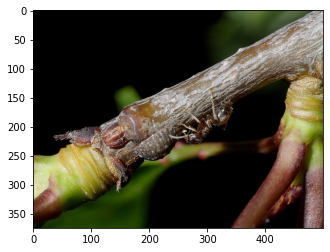

In [12]:
img = plt.imread(trn_fnames[15]) # covert to numpy array
plt.imshow(img); #show image

### Datasets and Dataloaders in PyTorch

- <h6>Dataset</h6>A set of images.
- <h6>Dataloader</h6>Loads data from dataset behind the scene using concurrent threads.

In [31]:
train_ds = datasets.ImageFolder(trn_dir) # we can add each component of transformation

In [14]:
train_ds.classes

['ants', 'bees']

In [15]:
train_ds.class_to_idx

{'ants': 0, 'bees': 1}

In [16]:
train_ds.root   #path in computer

'dataset/hymenoptera_data/train'

### Transformations

In [63]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image sz=224 we intiolize  at the begining
    transforms.ToTensor(),        # Tensor  # in pytourch we should tranform each picture to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #1-> mean(R,G,B) for Image Net dataset, 2->Standard deviation
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms) # execution transformation in eaxh folder train and validation
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

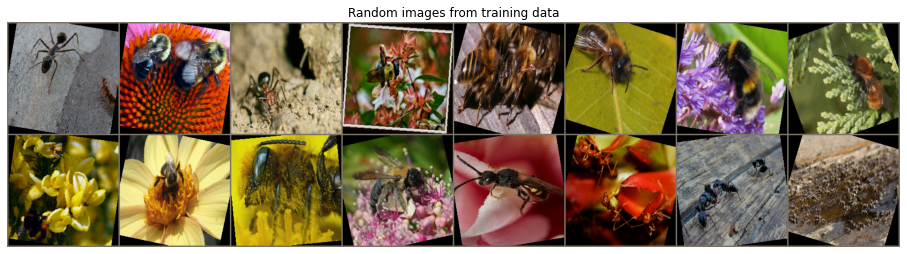

In [64]:
inputs, targets = next(iter(train_dl))  
out = torchvision.utils.make_grid(inputs, padding=3) # colect and put together like a grid
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data') #the number of picture =the bach size=32

### Transformations

Dataloader object uses these tranformations when loading data.

In [38]:
# Data augmentation and normalization just for training
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [39]:
train_ds = datasets.ImageFolder(trn_dir, train_transforms)
valid_ds = datasets.ImageFolder(val_dir, valid_transforms)

#### Dataloaders

In [40]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

In [41]:
train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

Train size: 244
Valid size: 153 (0.39)


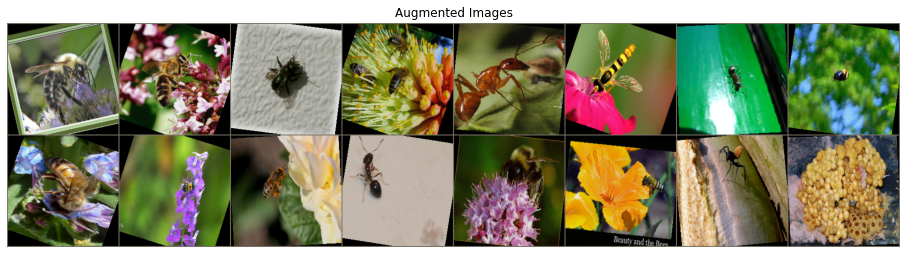

In [42]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images')

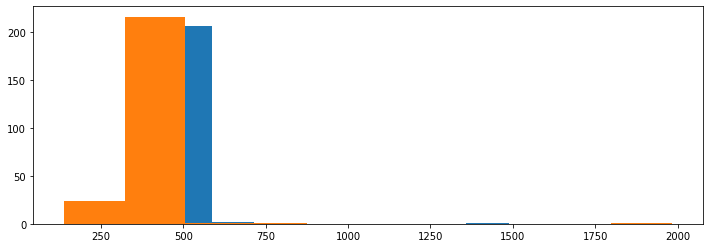

In [45]:
fnames = glob.glob(f'{trn_dir}/*/*.jpg')
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [46]:
class SimpleCNN(nn.Module):
    
    def __init__(self):      # this is an object and conv1 and conv2 are attributes
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),   # CNN layer 3 : deep of picture  
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2), #CNN layer
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(56 * 56 * 32, 12)     # fully connected layer
        
    def forward(self, x):   # x: a picture or a batch of picture.  In this layer we do all computation
        out = self.conv1(x)               
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)  # like reshape
        out = self.fc(out)
        return out

In [47]:
model = SimpleCNN()

# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [48]:
model

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=100352, out_features=12, bias=True)
)

## Loss function and optimizer

## Train

In [60]:
# load pre-trained ResNet18
model = load_pretrained_resnet50(model_path=None, num_classes=12)
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=2)

Epoch 1/2
----------
  train Loss: 0.80190 Acc: 0.71721
  valid Loss: 0.21962 Acc: 0.92810

Epoch 2/2
----------
  train Loss: 0.28962 Acc: 0.88115
  valid Loss: 0.14751 Acc: 0.93464

Training complete in 30m 13s
Best val Acc: 0.9346


### Analyze results

#### Accuracy on validation data

In [53]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [54]:
evaluate_model(model, valid_dl, device)

accuracy: 93.46


In [55]:
evaluate_model(model, train_dl, device)

accuracy: 99.59


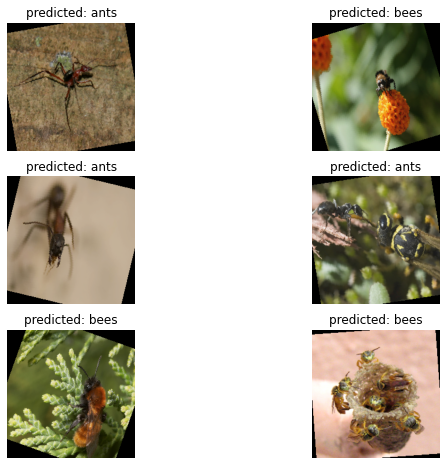

In [56]:
visualize_model(model, train_dl, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.51s/it]


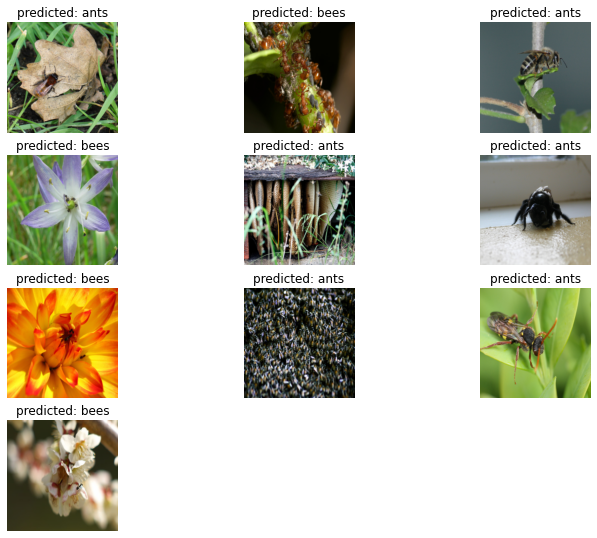

10 images out of 153 were misclassified.


In [57]:
plot_errors(model, valid_dl, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:40<00:00, 10.10s/it]


[[0.94 0.06]
 [0.07 0.93]]


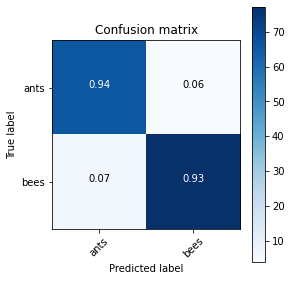

In [58]:
y_pred, y_true = predict_class(model, valid_dl, device)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))